# This jupyter notebook provides various analysis about shear results

In [23]:
%aiida
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## imports and settings

In [36]:
import os
import yaml
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
from copy import deepcopy
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from aiidaplus.plot import line_chart, BandsPlot, band_plot, bands_plot
from aiidaplus.get_data import get_structure_data, get_relax_data, get_phonon_data
from aiidaplus.utils import (get_qpoints_from_band_labels,
                             get_default_labels_of_twinmode)
from twinpy.lattice.brillouin import get_labels_for_twin
import seekpath

shear_dir = os.path.join('..', 'data', 'shear')

## extract yaml files

In [25]:
yamlfiles = [ name for name in os.listdir(shear_dir) if 'yaml' in name ]
yamlfiles.sort()
shears = []
for yamlfile in yamlfiles:
    with open(os.path.join(shear_dir, yamlfile)) as f:
        shears.append(yaml.load(f, Loader=yaml.SafeLoader))

## data details

In [26]:
print("# keys of each shear data")
print(shears[0].keys())
print("")

print("# calculator_settings")
pprint(shears[0]['calculator_settings'])
print("")

for key in ['parent', 'phonon_pks', 'relax_pks', 'relax_results', 'shear_conf', 'shear_ratios', 'strain']:
    print("# "+key)
    pprint(shears[0][key])
    print("")

# keys of each shear data
dict_keys(['calculator_settings', 'parent', 'phonon_pks', 'pk', 'relax_pks', 'relax_results', 'shear_conf', 'shear_ratios', 'strain'])

# calculator_settings
{'phonon': {'incar_settings': {'addgrid': True,
                               'ediff': 1e-08,
                               'encut': 300,
                               'gga': 'PS',
                               'ialgo': 38,
                               'ismear': 1,
                               'kpar': 2,
                               'lcharg': False,
                               'lreal': False,
                               'lwave': False,
                               'npar': 4,
                               'prec': 'Accurate',
                               'sigma': 0.4},
            'kpoints': {'mesh': [2, 2, 2], 'offset': [0, 0, 0.5]},
            'options': {'max_wallclock_seconds': 360000,
                        'queue_name': 'vega-a'},
            'phonon_conf': {'distance': 0.02,
  

## energies

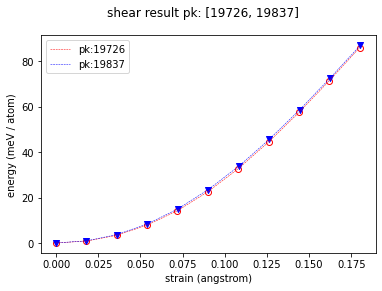

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
pks = []
for shear in shears:
    pks.append(shear['pk'])
    line_chart(
            ax,
            shear['strain'] * np.array(shear['shear_ratios']),
            (np.array(shear['relax_results']['energies']) \
                - shear['relax_results']['energies'][0]) \
                  * 1000 / shear['parent']['natoms'],
            "strain (angstrom)",
            "energy (meV / atom)",
            label = 'pk:' + str(shear['pk'])
            )
ax.legend()
fig.suptitle('shear result pk: %s' % pks)
plt.show()

[22, 22]

In [64]:
def get_labels_from_phonon(phonon):
    cell = phonon.get_unitcell().cell
    positions = phonon.get_unitcell().scaled_positions
    numbers = phonon.get_unitcell().get_atomic_numbers().tolist()
    structure = (cell, positions, numbers)
    return get_labels_for_twin(structure)

## band strcutures

In [33]:
labels = get_default_labels_of_twinmode(shears[0]['shear_conf']['twinmode'])
pmgstructure = load_node(shears[0]['parent']['pk']).get_pymatgen_structure()
qpoints = get_qpoints_from_band_labels(pmgstructure, labels)

shear_phonons = []
for shear in shears:
    phonons = []
    for pk in shear['phonon_pks']:
        try:
            _, phonon = get_phonon_data(pk, get_phonon=True)
        except:
            print("phonon calc seems to have failed pk:{}".format(pk))
        phonons.append(phonon)
    shear_phonons.append(phonons)

# band path is set automalically


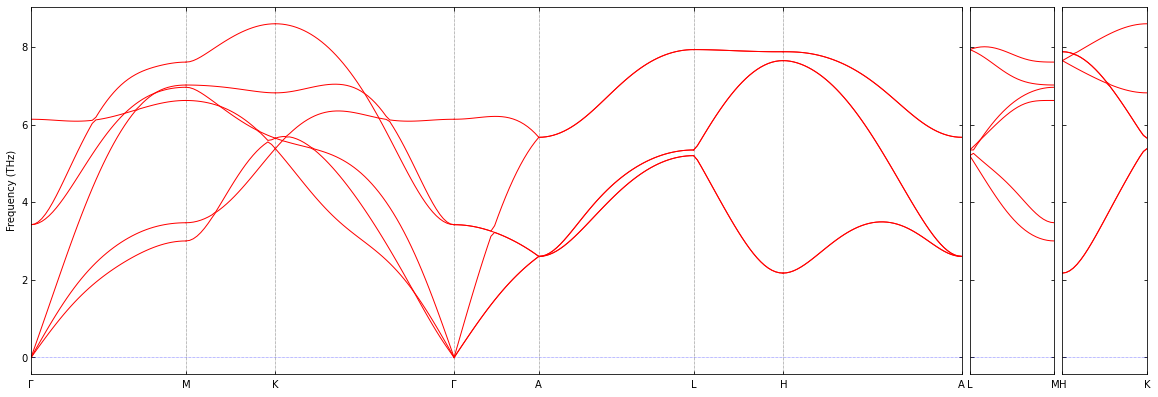

In [44]:
fig = plt.figure(figsize=(20,9))
bp = BandsPlot(fig, phonons=[shear_phonons[0][0]], is_auto=True)
bp.plot_bands()

In [39]:
bp._segment_qpoints_list

[[array([[0.        , 0.        , 0.        ],
         [0.5       , 0.        , 0.        ],
         [0.33333333, 0.33333333, 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.5       ],
         [0.5       , 0.        , 0.5       ],
         [0.33333333, 0.33333333, 0.5       ],
         [0.        , 0.        , 0.5       ]]),
  array([[0.5, 0. , 0.5],
         [0.5, 0. , 0. ]]),
  array([[0.33333333, 0.33333333, 0.5       ],
         [0.33333333, 0.33333333, 0.        ]])]]

### auto

# band path is set automalically


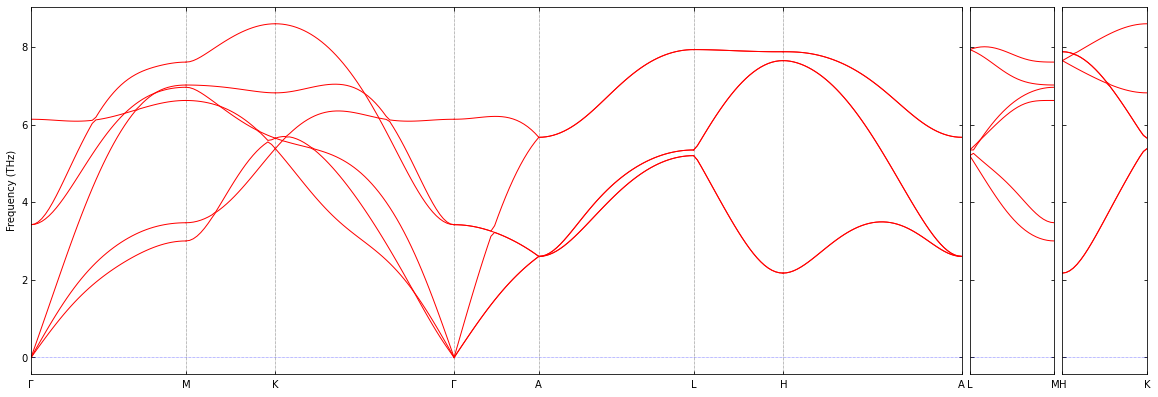

In [47]:
fig = plt.figure(figsize=(20,9))
band_plot(fig=fig,
          phonon=shear_phonons[0][0],
          is_auto=True)

### manually

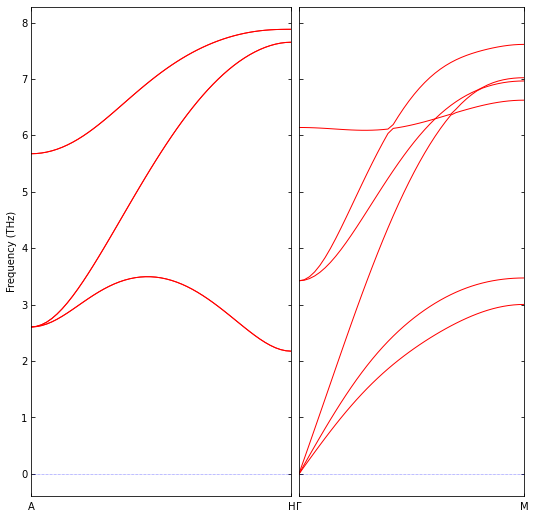

In [48]:
fig = plt.figure(figsize=(20,9))
band_labels = ['A', 'H', 'GAMMA', 'M']
segment_qpoints = np.array([[[0,0,1/2],
                             [1/3,1/3,1/2]],
                            [[0,0,0],
                             [1/2,0,0]]])
band_plot(fig=fig,
          phonon=shear_phonons[0][0],
          band_labels=band_labels,
          segment_qpoints=segment_qpoints,
          is_auto=False)

## comparing with two different calc conditions

# band path is set automalically
# band path is set automalically


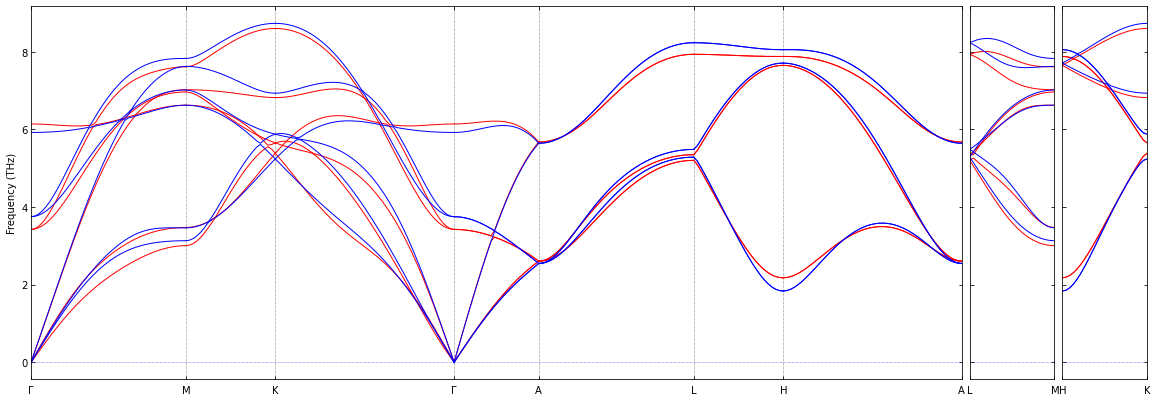

In [49]:
fig = plt.figure(figsize=(20,9))
bands_plot(fig=fig,
           phonons=[shear_phonons[0][0], shear_phonons[1][0]],
           is_auto=True)

# band path is set automalically
# band path is set automalically


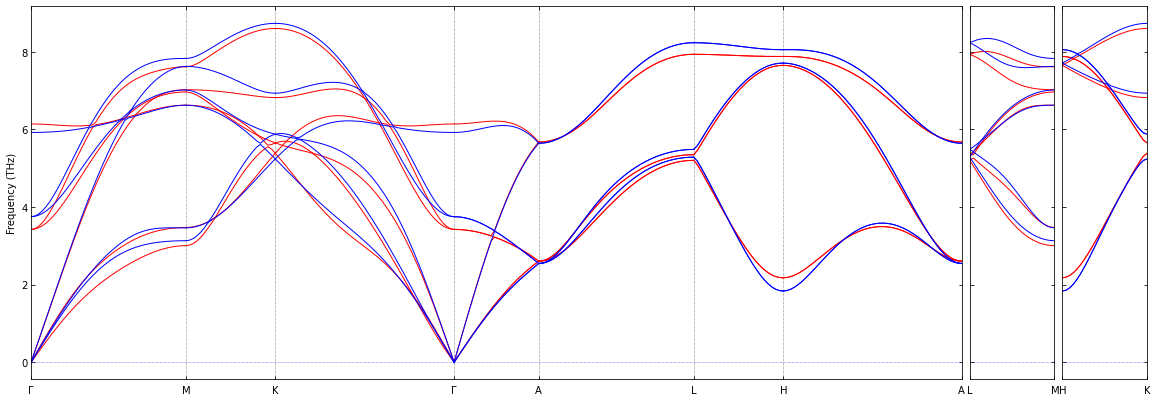

In [53]:
fig = plt.figure(figsize=(20,9))
band_labels = ['A', 'H', 'K', 'GAMMA', 'M', 'L']
segment_qpoints = np.array([[[0,0,1/2],
                             [1/3,1/3,1/2],
                             [1/3,1/3,0],
                             [0,0,0],
                             [1/2,0,0],
                             [1/2,0,1/2]]])

bands_plot(fig=fig,
           phonons=[shear_phonons[0][0], shear_phonons[1][0]],
           band_labels=band_labels,
           segment_qpoints=segment_qpoints,
           is_auto=True)

## All band paths

### TODO
some points are sharp which is strange

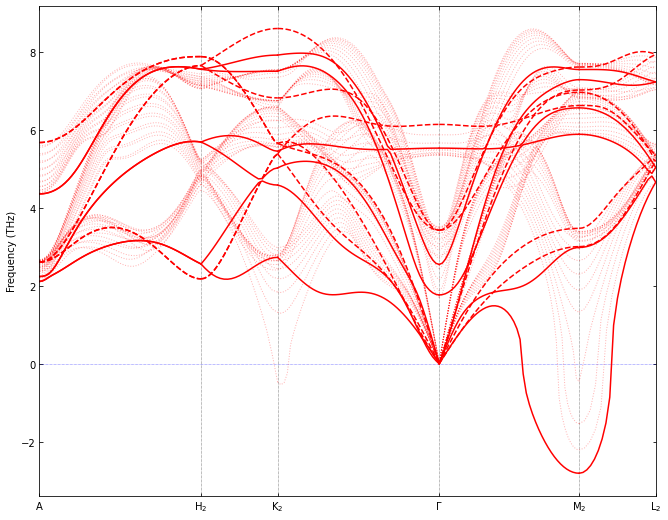

In [108]:
fig = plt.figure(figsize=(20,9))
band_labels = ['A', 'H_2', 'K_2', 'GAMMA', 'M_2', 'L_2']
segment_qpoints_list = []
for phonon in shear_phonons[0]:
    label_qpoints = get_labels_from_phonon(phonon)
    segment_qpoints = []
    for label in band_labels:
        segment_qpoints.append(label_qpoints['label_qpoints'][label])
    segment_qpoints_list.append(np.array([segment_qpoints]))
# bp = BandsPlot(fig=fig,
#                phonons=shear_phonons[0],
#                band_labels=band_labels,
#                segment_qpoints_list=segment_qpoints_list)
bands_plot(fig=fig,
           phonons=shear_phonons[0],
           band_labels=band_labels,
           segment_qpoints_list=segment_qpoints_list,
           is_trajectory=True,
           c='r',
           xscale=18,
           is_auto=False)
# bp.plot_bands()

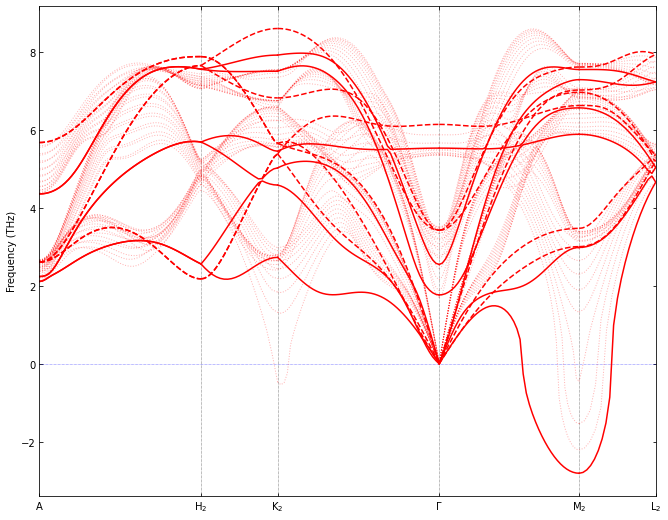

In [112]:
fig = plt.figure(figsize=(20,9))
band_labels = ['A', 'H_2', 'K_2', 'GAMMA', 'M_2', 'L_2']
# band_labels = ['A', 'H_1', 'K_1', 'GAMMA', 'M_1', 'L_1']
segment_qpoints_list = []
for phonon in shear_phonons[0]:
    label_qpoints = get_labels_from_phonon(phonon)
    segment_qpoints = []
    for label in band_labels:
        segment_qpoints.append(label_qpoints['label_qpoints'][label])
    segment_qpoints_list.append(np.array([segment_qpoints]))
# bp = BandsPlot(fig=fig,
#                phonons=shear_phonons[0],
#                band_labels=band_labels,
#                segment_qpoints_list=segment_qpoints_list)
bands_plot(fig=fig,
           phonons=shear_phonons[0],
           band_labels=band_labels,
           segment_qpoints_list=segment_qpoints_list,
           is_trajectory=True,
           c='r',
           xscale=18,
           is_auto=False)
# bp.plot_bands()

In [97]:
for i in range(len(bp.phonons[1].band_structure.qpoints)):
    print(bp.phonons[1].band_structure.qpoints[i][-1])

[-0.33470947  0.66529053  0.5       ]
[-0.33484183  0.66515817  0.        ]
[0. 0. 0.]
[-0.5  0.5  0. ]
[-0.5  0.5  0.5]


In [98]:
get_labels_from_phonon(shear_phonons[0][1])

{'spacegroup_number': 12,
 'label_tags': {'GAMMA': 'GAMMA',
  'M_1': 'V_2',
  'M_2': 'Y_2',
  'K_1': 'C',
  'K_2': 'C_2',
  'A': 'A',
  'L_1': 'L_2',
  'L_2': 'M_2',
  'H_1': 'D_2',
  'H_2': 'D'},
 'label_qpoints': {'GAMMA': [0.0, 0.0, 0.0],
  'M_1': [0.0, 0.5, 0.0],
  'M_2': [-0.5, 0.5, 0.0],
  'K_1': [0.33484182767682713, 0.33484182767682713, 0.0],
  'K_2': [-0.33484182767682713, 0.6651581723231729, 0.0],
  'A': [0.0, 0.0, 0.5],
  'L_1': [0.0, 0.5, 0.5],
  'L_2': [-0.5, 0.5, 0.5],
  'H_1': [0.33470946896733245, 0.33470946896733245, 0.5],
  'H_2': [-0.33470946896733245, 0.6652905310326676, 0.5]},
 'default_paths': ['A',
  'H_2',
  'L_2',
  'A',
  'GAMMA',
  'K_2',
  'M_2',
  'GAMMA',
  'M_1',
  'K_1',
  'GAMMA',
  'A',
  'L_1',
  'H_1',
  'A']}

# band path is set automalically
# band path is set automalically
# band path is set automalically
# band path is set automalically
# band path is set automalically
# band path is set automalically
# band path is set automalically
# band path is set automalically
# band path is set automalically
# band path is set automalically
# band path is set automalically


TypeError: unsupported operand type(s) for /: 'list' and 'list'

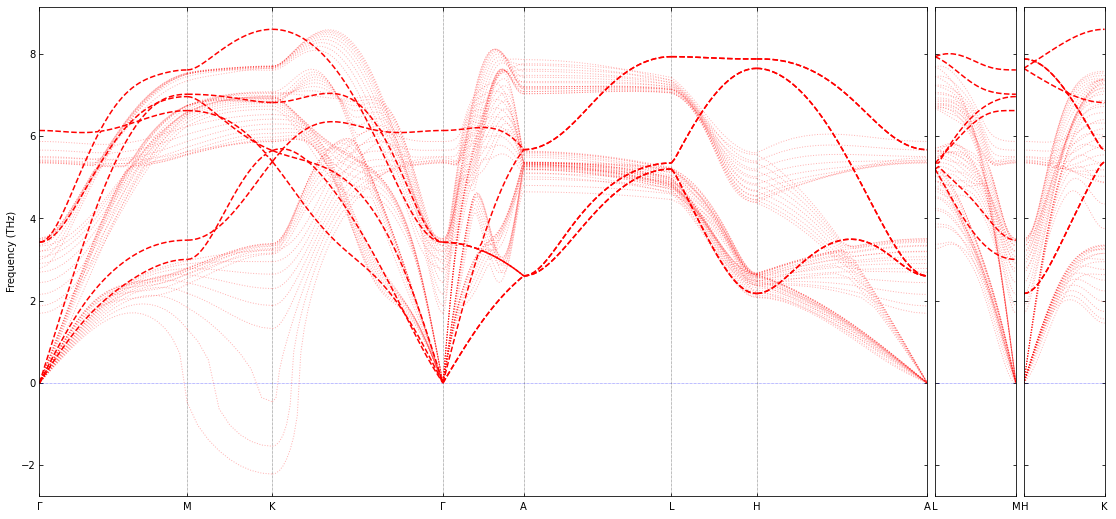

In [54]:
fig = plt.figure(figsize=(20,9))
# band_labels = ['A', 'H', 'K', 'GAMMA', 'M', 'L']
# segment_qpoints = np.array([[[0,0,1/2],
#                              [1/3,1/3,1/2],
#                              [1/3,1/3,0],
#                              [0,0,0],
#                              [1/2,0,0],
#                              [1/2,0,1/2]]])
bands_plot(fig=fig,
           phonons=shear_phonons[0],
           band_labels=band_labels,
           segment_qpoints=segment_qpoints,
           is_trajectory=True,
           c='r',
           xscale=18,
           is_auto=True)

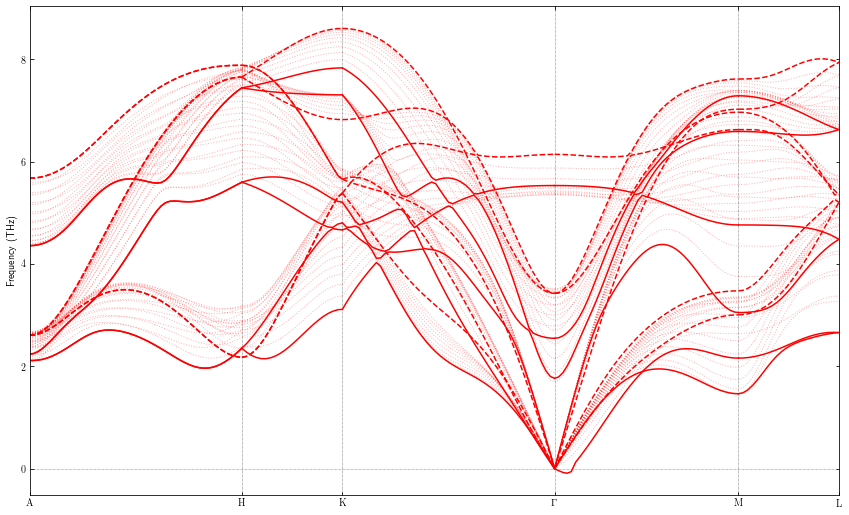

In [679]:
fig = plt.figure(figsize=(20,9))
band_labels = ['A', 'H', 'K', 'GAMMA', 'M', 'L']
segment_qpoints = np.array([[[0,0,1/2],
                             [1/3,1/3,1/2],
                             [1/3,1/3,0],
                             [0,0,0],
                             [1/2,0,0],
                             [1/2,0,1/2]]])
bands_plot(fig=fig,
           phonons=shear_phonons[0],
           band_labels=band_labels,
           segment_qpoints=segment_qpoints,
           is_trajectory=True,
           c='r',
           xscale=18,
           is_auto=False)

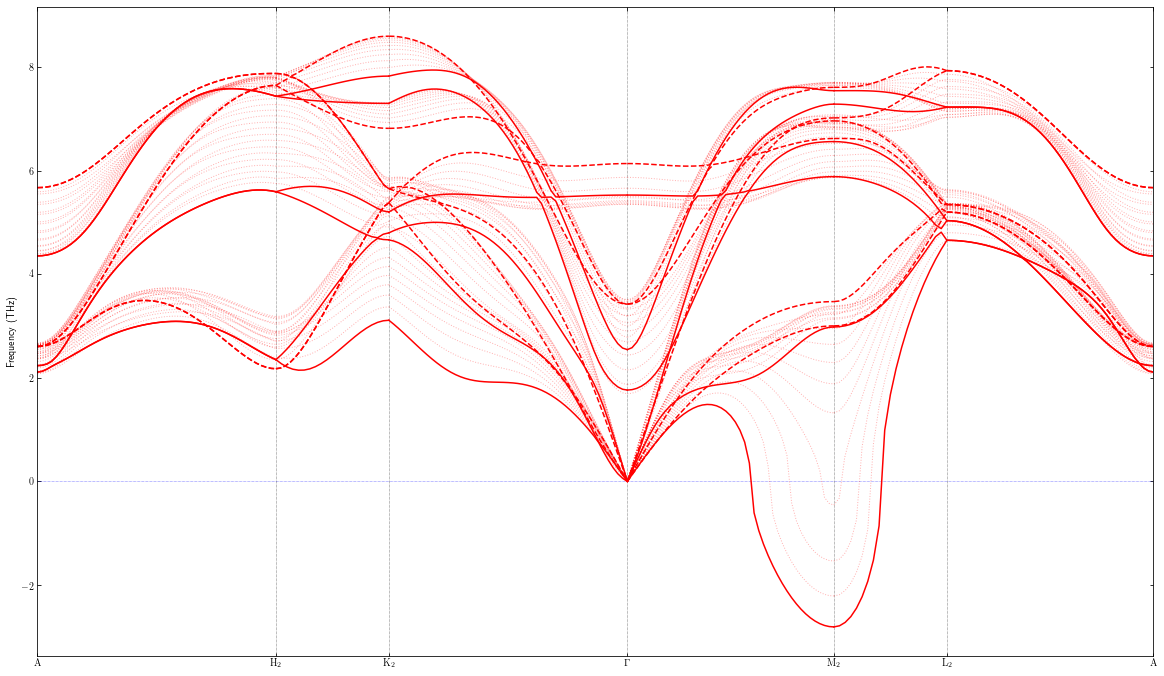

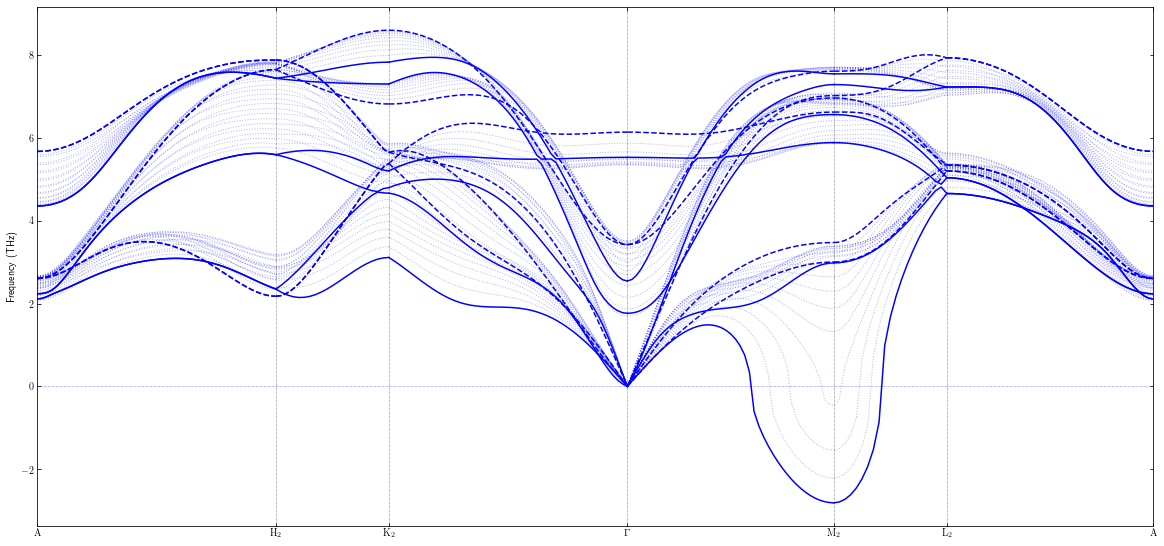

In [675]:
fig1 = plt.figure(figsize=(20,30))
fig2 = plt.figure(figsize=(20,30))
all_labels = get_labels_for_twin()
band_labels = ['A', 'H_2', 'K_2', 'GAMMA', 'M_2', 'L_2', 'A']
segment_qpoints = []
for band_label in band_labels:
    segment_qpoints.append(all_labels[band_label])
segment_qpoints = np.array([segment_qpoints])

bands_plot(fig=fig1,
           phonons=shear_phonons[0],
           band_labels=band_labels,
           segment_qpoints=segment_qpoints,
           is_trajectory=True,
           c='r',
           is_auto=False)
bands_plot(fig=fig2,
           phonons=shear_phonons[0],
           band_labels=band_labels,
           segment_qpoints=segment_qpoints,
           is_trajectory=True,
           c='b',
           xscale=25,
           is_auto=False)

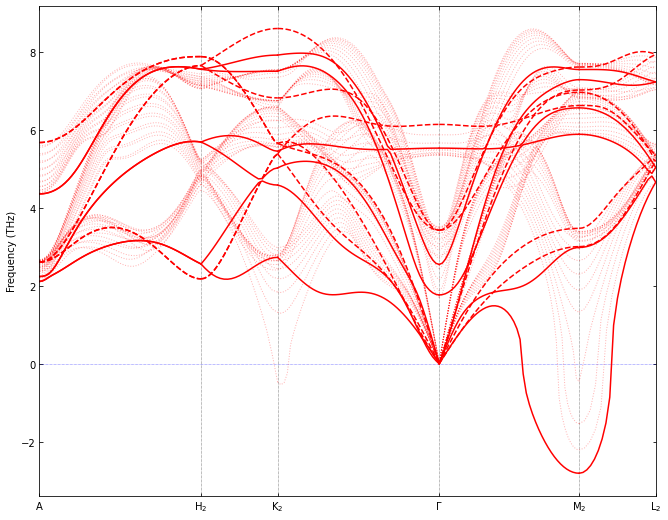

In [113]:
fig = plt.figure(figsize=(20,9))
band_labels = ['A', 'H_2', 'K_2', 'GAMMA', 'M_2', 'L_2']
# band_labels = ['A', 'H_1', 'K_1', 'GAMMA', 'M_1', 'L_1']
segment_qpoints_list = []
for phonon in shear_phonons[0]:
    label_qpoints = get_labels_from_phonon(phonon)
    segment_qpoints = []
    for label in band_labels:
        segment_qpoints.append(label_qpoints['label_qpoints'][label])
    segment_qpoints_list.append(np.array([segment_qpoints]))
# bp = BandsPlot(fig=fig,
#                phonons=shear_phonons[0],
#                band_labels=band_labels,
#                segment_qpoints_list=segment_qpoints_list)
bands_plot(fig=fig,
           phonons=shear_phonons[0],
           band_labels=band_labels,
           segment_qpoints_list=segment_qpoints_list,
           is_trajectory=True,
           c='r',
           xscale=18,
           is_auto=False)
# bp.plot_bands()